# Move the Block

Taking over from the previous lab report, now we are going to figure out some of the search algorithms that can help us solve the puzzle of moving the block. 

First of all of the steps, we decided to define the Klotski maze as a 4 x 4 puzzle which will make it easier for us to experiment with how different search algorithms have different efficiencies for these specific problems.

These are the important libraries that we will use for our entire lab 8.

### Libraries
- `numpy`
- `pandas`
- `seaborn`
- `matplotlib`
- `network`
- `copy`
- `queue`
- `collections`

In [2]:
#import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import copy
import queue
from collections import deque

# Visualising our game's initial settings
To differentiate the space and the different blocks in our 4 x 4 puzzle, we give each of them a specific number and respective colors. We then initialize the positions for all the blocks every game. The table shown below contains the type of blocks, respective numbers, shapes, colors and initial positions.

|Type of Block	|  Number |Shape|	Colour  | Initial position|
| ---    | ---   | ---     | --- | --- |
|Empty Space | 0 	| Square | Black	   | All the empty position|
|Blocking Cube 1 |  1	| Horizontal | Purple  	   |3 , 1|
|Blocking Cube 2 | 2 | Vertical | Red   | 0 , 2|
|Blocking Cube 3 | 3  	| Vertical | Orange  | 1 , 3|
|Goal Block | 4 | Horizontal	| Yellow | 1 , 0|

When the **Yellow Goal Block** is at point [1,2], it definitely can move out from the puzzle. Thus, we aim to move **Yellow Goal Block** with index 4 to the escape point [1,2].

In [3]:
#create game, different indexes represent different blocks on the board
#define goal position (escape position)
game = {
    "blocks": [
        {"index": 1, "shape": [1, 2], "position": [3, 1]},
        {"index": 2, "shape": [2, 1], "position": [0, 2]},
        {"index": 3, "shape": [2, 1], "position": [1, 3]},
        {"index": 4, "shape": [1, 2], "position": [1, 0]}
    ],
    "boardSize": [4, 4],
    "escapePoint": [1,2],
}

# Initial board setup
board = [[0 for _ in range(game["boardSize"][0])] for _ in range(game["boardSize"][1])]

# Place blocks on the board
for block in game["blocks"]:
    shape = block["shape"]
    position = block["position"]
    for i in range(shape[0]):
        for j in range(shape[1]):
            board[position[0] + i][position[1] + j] = block["index"]


After defining all the elements we need for our puzzle, we want to visualize it. Firstly, we are using only the numbers and symbols to visualize it. However, we have faced a reading inconvenience. Hence, we decided to visualize it using a heatmap in that we can mention the number and different colors for each block. 

We make two printing methods into two distinct functions that use list containing all information, `board`, as the parameter : 
1. `print_board(board)`
2. `display_heatmap(board)`


In [4]:
#Printing the whole board in numbers
def print_board(board):
    for row in board:
        print(" ".join(str(cell) if cell != 0 else "#" for cell in row))

#Visualize the whole board using heatmap
def display_heatmap(board):
    df = pd.DataFrame(board)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, cmap="inferno", linewidths=0.1, linecolor="black", annot=True, fmt="d", cbar=False, square=True)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.title("Klotski Maze")
    plt.show()


Initial Position of Blocks:
# # 2 #
4 4 2 3
# # # 3
# 1 1 #

Displaying Heatmap:


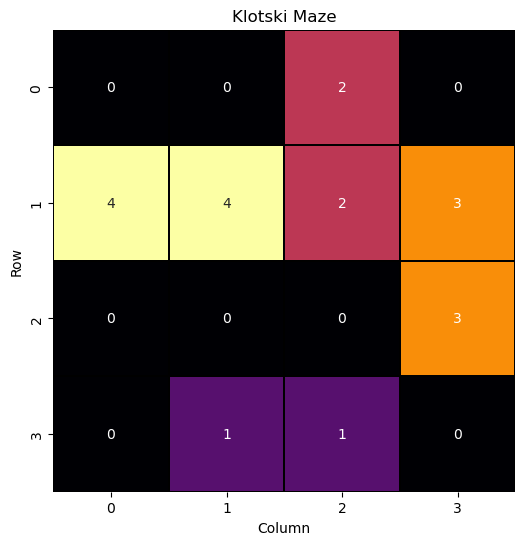

In [5]:
print("\nInitial Position of Blocks:")
print_board(board)

print("\nDisplaying Heatmap:")
display_heatmap(board)

<br>

After choosing the visualization method, we put all the information into a matrix that can facilitate the rest of our work. The function `convert_board(game)` can make this transformation using the parameter **game** that contains the information of the game.  

<br>

In [6]:
def convert_board(game):
    board = [[0 for _ in range(game["boardSize"][0])] for _ in range(game["boardSize"][1])]

    # Place blocks on the board
    for block in game["blocks"]:
        shape = block["shape"]
        position = block["position"]
        for i in range(shape[0]):
            for j in range(shape[1]):
                board[position[0] + i][position[1] + j] = block["index"]
    return board

initial_board = convert_board(game)
print_board(initial_board)

# # 2 #
4 4 2 3
# # # 3
# 1 1 #


# Define repeatedly used function

These are the functions that will be repeatedly used in the rest of this lab assignment. 

- `find_block(board, block_index)`: find the position of a specific block <br>
- `get_shape(block_index)`: get the shape of a specific block <br>
- `is_valid_move(board, block_index, direction)`: determine if the move of a block is valid <br>
- `move_block(board, block_index, direction)`: move a specific block in a specific direction by one step <br>
- `revert_board(board, block_index, direction)`: return the board to the current state after creating a new board to be append into the queue <br>
- `print_queue(queue)`: print the whole queue using for the debug in this lab assignment<br>


In [7]:
def find_block(board, block_index):
    for i in range(4):
        for j in range(4):
            if(board[i][j] == block_index):
                return i,j
            
def get_shape(block_index):
    if block_index == 1 or block_index == 4:
        return 1,2
    else:
        return 2,1

def is_valid_move(board, block_index, direction):
        x, y = find_block(board, block_index)
        shape_x, shape_y = get_shape(block_index)
        
        if direction == "up" and shape_x == 2 and shape_y == 1:
            return x > 0 and board[x-1][y] == 0
        elif direction == "down" and shape_x == 2 and shape_y == 1:
            return x < game["boardSize"][0] - 2 and board[x+2][y] == 0
        elif direction == "left" and shape_x == 1 and shape_y == 2:
            return y > 0 and board[x][y-1] == 0
        elif direction == "right" and shape_x == 1 and shape_y == 2:
            return y < game["boardSize"][1] - 2 and board[x][y+2] == 0
        return False
    
def move_block(board, block_index, direction):
    x, y = find_block(board, block_index)
    if (is_valid_move(board, block_index, direction)==False):
        print("invalid move!")
        return board.copy()
    
    new_board = board
        
    if direction == "up":
        new_board[x-1][y] = block_index
        new_board[x+1][y] = 0
    elif direction == "down":
        new_board[x+2][y] = block_index
        new_board[x][y] = 0
    elif direction == "left":
        new_board[x][y-1] = block_index
        new_board[x][y+1] = 0
    elif direction == "right":
        new_board[x][y+2] = block_index
        new_board[x][y] = 0
    return new_board

def revert_board(board, block_index, direction):
    if direction == "up":
        current_board = move_block(board,block_index,"down")
    elif direction == "down":
        current_board = move_block(board,block_index,"up")
    elif direction == "left":
        current_board = move_block(board,block_index,"right")
    else:
        current_board = move_block(board,block_index,"left")
    return current_board

def print_queue(queue):
    print("The Queue")
    for item in queue:
        board, moves = item
        print("Current Board:")
        print_board(board)
        print("Moves:", moves)
        print()

# Displaying the Puzzle in a Graph

Before applying the algorithms to the puzzle, we tend to find out all the possibilities of the states of the puzzles. We then define a function `board_to_graph(game)` that prints out all the possible states. The algorithms we apply are based on the search algorithms of a graph, from the graph below we can notice that there are several possibilities for a single state. Hence, that's our goal that find the most efficient algorithm from the next **7** algorithms that we will use later. 

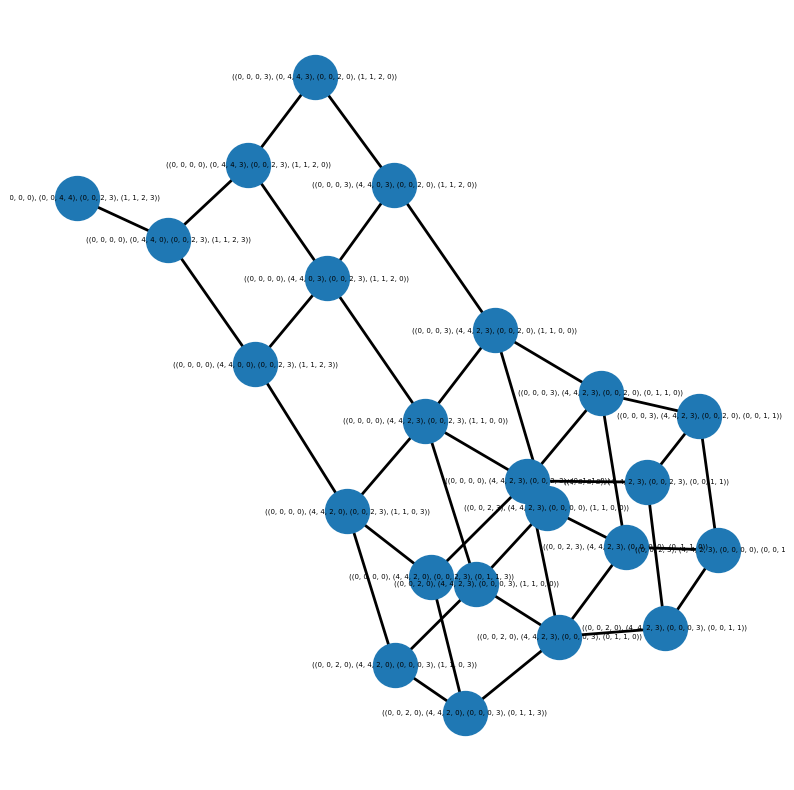

In [9]:
def board_to_graph(game):
    ''' Converts a sliding block puzzle board to corresponding graph
        Input : 2D list representing the board state
        Output : Graph corresponding to the board state
    '''
    
    start_board = convert_board(game) #convert the information into a matrix
    queue = deque([start_board]) #putting the initial state of the puzzle
    visited = set() #use to store the visited states
    board_graph = nx.Graph() #define the function of printing the graph
    
    #finding all the states of the puzzle
    while queue: 
        current_board = queue.popleft()
        init_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, init_board)) in visited:
            for i in range(4):
                block_index = i + 1
                for direction in ["up", "down", "left", "right"]:
                    if is_valid_move(current_board, block_index, direction):
                        new_board = move_block(current_board, block_index, direction)
                        board_graph.add_edge(tuple(map(tuple, init_board)), tuple(map(tuple, new_board)))
                        revert_board(new_board, block_index, direction)
            continue
        visited.add(tuple(map(tuple, init_board)))

        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, copy.deepcopy(new_board))) not in visited:
                        board_graph.add_node(tuple(map(tuple, copy.deepcopy(new_board))))
                    board_graph.add_edge(tuple(map(tuple, init_board)), tuple(map(tuple, copy.deepcopy(new_board))))
                    queue.append((copy.deepcopy(new_board)))
                    revert_board(new_board, block_index, direction)

    return board_graph

# Convert the board state to a graph
board_graph = board_to_graph(game)

# Helper function to display the graph
def show_graph(graph):
    
    f = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)

    nx.draw_networkx_nodes(graph, pos, node_size=1000)
    nx.draw_networkx_edges(graph, pos, width=2)
    nx.draw_networkx_labels(graph, pos, font_size=5)

    plt.axis("off")
    plt.show()

# Display the graph
show_graph(board_graph)


# Method 1: Breadth First Search (BFS)

Breadth First Search is a searching algorithm that visits all the nodes in a **level-by-level** manner. It first will visit all the neighbors of the current node before going to the nodes in the next depth level. It supports us in finding the shortest path from the initial node to the target node. Thus, it will give us the most efficient way to reach our goal. The result shows that it uses 23 visits of nodes to find the optimal solution to this puzzle.

[(1, 'left'), (2, 'down'), (2, 'down'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  23

Displaying Heatmap:


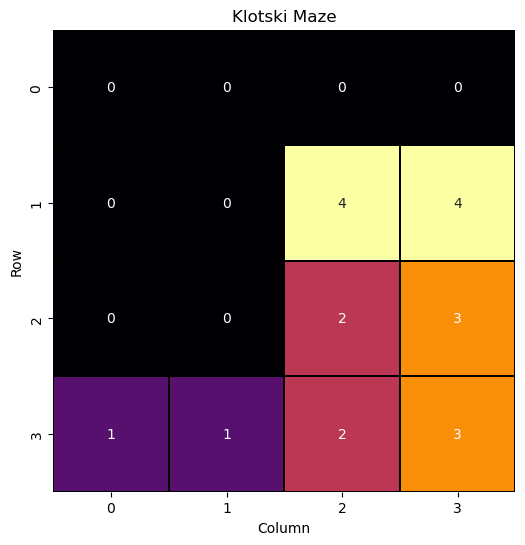

In [8]:
def solve_bfs(game):
    start_board = convert_board(game)
        
    visited = set()
    queue = deque([(start_board, [])])
    num_moves = 0
    final_board = None
    nodes_visited = 0
        
    while queue:
        current_board, moves = queue.popleft()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
            
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
            
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    queue.append((copy.deepcopy(new_board), moves + [(block_index, direction)]))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
                    
    print(moves)
    return final_board, num_moves, nodes_visited    

final_board, num_moves, nodes_visited = solve_bfs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 2: Depth First Search (DFS)

Depth First Search (DFS) in a graph is similar to depth-first search in a tree. However, to prevent visiting the same node repeatedly, we mark visited states, which helps us reach the goal more efficiently. Nevertheless, the method of traversing to the deepest node may not necessarily lead us to the shortest path in the graph, but rather a route to reach the goal. The results also show that it requires 23 visits but results in 18 movements, which is relatively high.

[(3, 'down'), (2, 'down'), (3, 'up'), (3, 'up'), (2, 'up'), (1, 'left'), (3, 'down'), (3, 'down'), (2, 'down'), (3, 'up'), (3, 'up'), (2, 'down'), (4, 'right'), (3, 'down'), (4, 'left'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 18

Total Nodes Visited:  23

Displaying Heatmap:


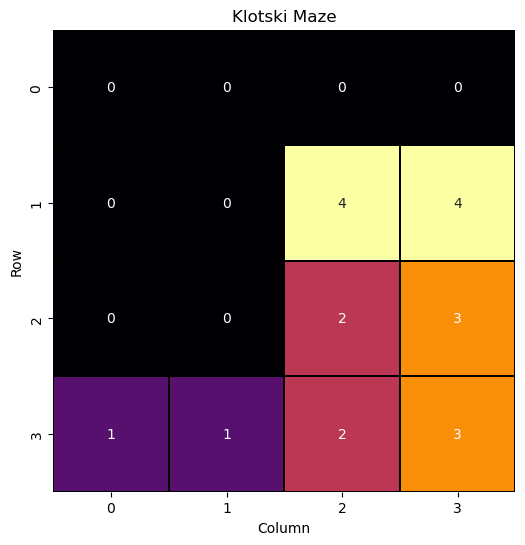

In [9]:
def solve_dfs(game):
    start_board = convert_board(game)
        
    visited = set()
    stack = deque([(start_board, [])])
    num_moves = 0
    final_board = None
    nodes_visited = 0
        
    while queue:
        current_board, moves = stack.pop()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
            
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
            
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    stack.append((copy.deepcopy(new_board), moves + [(block_index, direction)]))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
                    
    print(moves)
    return final_board, num_moves, nodes_visited    

final_board, num_moves, nodes_visited = solve_dfs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 3: Uniform Cost Search (UCS)

Uniform Cost Search is an advanced version of Breadth First Search. By considering the cost of movement from the current node to the next node, it can directly choose the route that costs the least, optimizing our search. However, since all movements in this puzzle have a cost **equal to 1**, the result of the uniform cost search will be the same as the result of the breadth-first search. Our results confirm this. 

[(1, 'left'), (2, 'down'), (2, 'down'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  23

Displaying Heatmap:


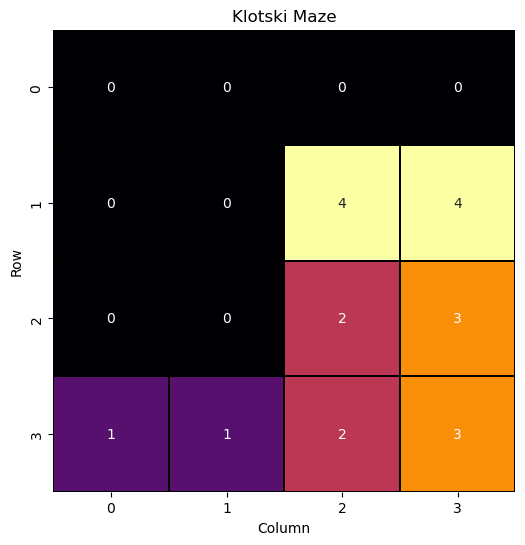

In [10]:
#import PriorityQueue from queue to calculate the cost of each movement
from queue import PriorityQueue

def solve_ucs(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, (start_board, [])))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        cost, (current_board, moves) = priority_queue.get()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    priority_queue.put((cost + 1, (copy.deepcopy(new_board), moves + [(block_index, direction)])))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
        
    print(moves)
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_ucs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 4: Greedy-Search (GS)

Greedy-Search is a search algorithm that chooses the next node by choosing the node that has the least cost to the goal. Hence, theoretically, it will be the most efficient way to find the solution. However, during the processing of searching, it may encounter the issue of incompleteness as it only chooses the node that has the least cost which may lead us to the dead end. Luckily, in our puzzle, we do not face this difficulty and we have a relatively low number of visits to get the optimal solution. The result is 7 visits of nodes and get the solution with 6 moves. 

Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  7

Displaying Heatmap:


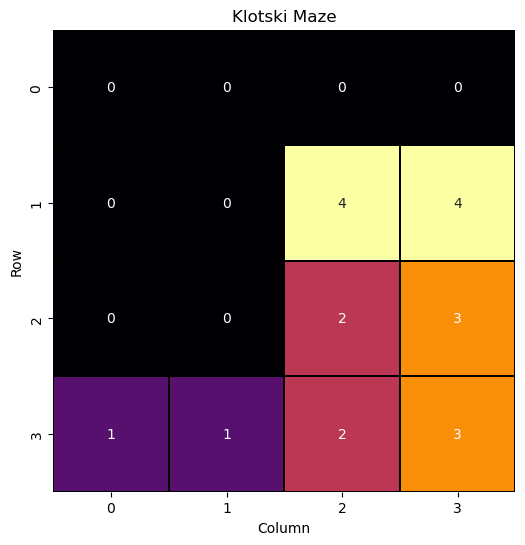

In [11]:
def heuristic(board):
    i,j = find_block(board,4)
    return abs(3-(j+1))

def solve_gs(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, start_board))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        _, current_board = priority_queue.get()
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    priority = heuristic(new_board)  # Greedy search uses only heuristic as priority
                    priority_queue.put((priority, copy.deepcopy(new_board)))
                    revert_board(new_board, block_index, direction)
        
    num_moves = len(visited) - 1  # Number of visited nodes minus the start node
    
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_gs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 5: A *Search

A* Search is an algorithm that combines Greedy Search with Uniform-Cost Search. It chooses the next node by considering both the cost to reach the next node and the cost to reach the goal. Therefore, it may not encounter the incompleteness issue. However, unavoidably, the expectation of efficiency for this algorithm may not be the fastest due to the complex considerations involved in choosing the next node. The result we obtained involved visiting 20 nodes to find the solution in 6 moves.

[(1, 'left'), (2, 'down'), (2, 'down'), (4, 'right'), (3, 'down'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  20

Displaying Heatmap:


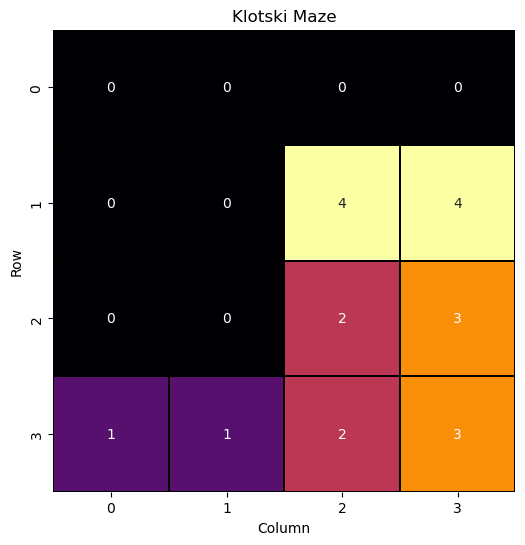

In [12]:
def solve_a_star(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, (start_board, [])))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        _, (current_board, moves) = priority_queue.get()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    cost = len(moves) + 1 + heuristic(new_board)  # Actual cost + heuristic estimate
                    priority_queue.put((cost, (copy.deepcopy(new_board), moves + [(block_index, direction)])))  # Add the new move to moves
                    revert_board(new_board, block_index, direction)
        
    print(moves)
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_a_star(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 6: Bidirectional Search (BS)

Bidirectional Search is a special search algorithm that starts from both the starting node and the goal node. The method of choosing the next node is similar to the method that A * Search used to choose the next node. When the nodes from two opposite directions intersect with each other, then the searching process will be terminated. It is a relatively more efficient method as most cases the search process will only required to run through half of the graph instead of the whole graph, which can reduce the searching time by half. The result we get is a total of visiting 13 nodes to get the results in 6 moves. 

[(1, 'left'), (2, 'down')]
[(4, 'left'), (3, 'up'), (4, 'left')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  13

Displaying Heatmap:


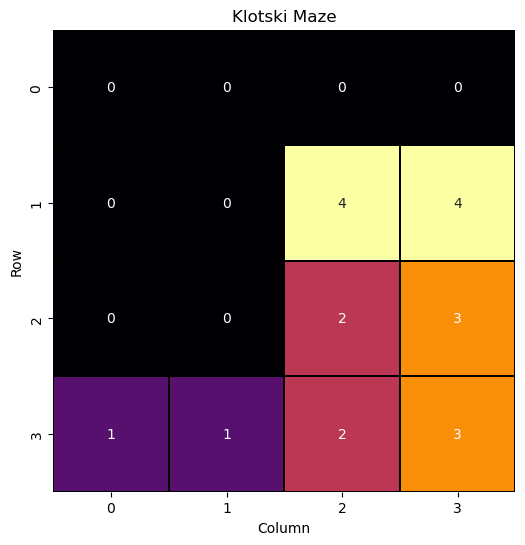

In [13]:
def solve_bs(game):
    start_board = convert_board(game)
    goal_board = [[0, 0, 0, 0], [0, 0, 4, 4], [0, 0, 2, 3], [1, 1, 2, 3]]  
    
    start_visited = set()
    start_queue = deque([(start_board, [])])
    start_visited.add(tuple(map(tuple, start_board)))
    
    goal_visited = set()
    goal_queue = deque([(goal_board, [])])
    goal_visited.add(tuple(map(tuple, goal_board)))
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while start_queue and goal_queue:
        # Forward search from start state
        current_board, moves1 = start_queue.popleft()
        nodes_visited += 1
        
        if tuple(map(tuple, current_board)) in goal_visited:
            final_board = current_board
            num_moves = len(moves1)+len(moves2)+1
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in start_visited:
                        start_queue.append((copy.deepcopy(new_board), moves1 + [(block_index, direction)]))
                        start_visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
        
        # Backward search from goal state
        current_board, moves2 = goal_queue.popleft()
        nodes_visited += 1
        
        if tuple(map(tuple, current_board)) in start_visited:
            final_board = current_board
            num_moves = len(moves1)+len(moves2)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in goal_visited:
                        goal_queue.append((copy.deepcopy(new_board), moves2 + [(block_index, direction)]))
                        goal_visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
    
    print(moves1)
    print(moves2)
    return goal_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_bs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 7: Iterative Deepening A* (IDA*)

Similar to Iterative Deepening Depth First Search, it has the same concept of optimizing the memory space by changing the method of choosing the next node to the method of A * search. It is more efficient than the depth-first search and uses less memory than the original A * search. However, when we are implementing the algorithm, we face some issues in that the algorithm cannot generate the correct answer. After several trials, we still could not tackle this problem, thus after consideration, we decided to abandon this algorithm and its result. The main problem we thought that is the calculation of the steps may have some problems as it successfully goes to the goal state but the number of moves is impossible as it should be greater or equal to 6. 

Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 3

Total Nodes Visited:  57

Displaying Heatmap:


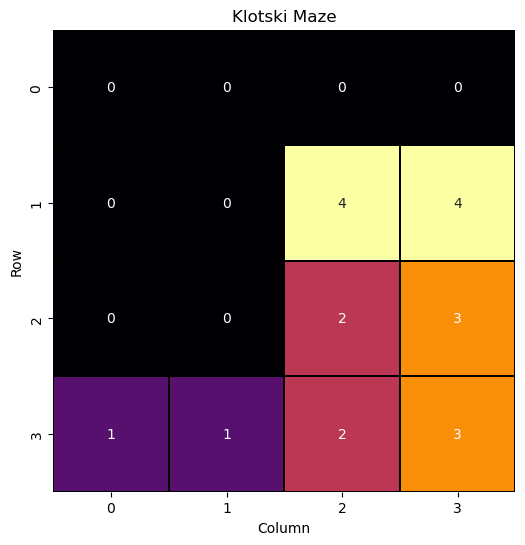

In [14]:
def solve_ida(game):
    start_board = convert_board(game)
    threshold = heuristic(start_board)
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while True:
        result, new_threshold, visited = ida_star_dfs(start_board, threshold)
        nodes_visited += visited
        
        if result is not None:
            final_board = result
            num_moves = len(result) - 1  # Number of moves is the depth of the solution path
            break
        
        if new_threshold == float('inf'):
            break
        
        threshold = new_threshold
    
    return final_board, num_moves, nodes_visited

def ida_star_dfs(board, threshold):
    stack = [(board, [], 0)]
    visited = set()
    visited.add(tuple(map(tuple, board)))
    
    nodes_visited = 0
    
    while stack:
        current_board, moves, cost = stack.pop()
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            return current_board, float('inf'), nodes_visited  # Solution found
        
        f = cost + heuristic(current_board)
        
        if f > threshold:
            return None, f, nodes_visited  # Exceeds threshold
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in visited:
                        stack.append((copy.deepcopy(new_board), moves + [(block_index, direction)], cost + 1))
                        visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
    
    return None, threshold, nodes_visited  # Solution not found within threshold

final_board, num_moves, nodes_visited = solve_ida(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Comparing effectiveness of different algorithms 

|Algorithms |Total Number of Moves| Total Nodes Visited|
|---|---|---|
|Breadth First Search (BFS)| 6 | 23 |
|Depth First Search (DFS) | 18 | 23 |
|Uniform Cost Search (UCS) | 6 | 23 |
|Greedy Search (GS) | 6 | 7 |
|A* Search | 6 | 20 |
|Bidirectional Search (BS) | 6 | 13 |
|Iterative Deepening A* (IDA*) | 3 | 57 |

With that, we conclude that the most effective algorithm to solve this moving block puzzle is **Bidirectional Search**. The reason why we not choose Greedy Search as the most effective algorithm is the completeness. Although Greedy Search can find the optimal solution in the least numbers of visit, it may face the incompleteness due to the method of choosing next nodes. However, since **Bidirectional Search** are the method that move from the both sides, it can make sure the completeness and also maintain its own efficiency. T